In [252]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy
from scipy.optimize import curve_fit

In [253]:
# open file（ex : 2016/11/02 Jupiter）
hdu = fits.open("/mnt/castor/home1/amigos/kohno/NANTEN2/std_ps/n20181003045146_12CO_2-1_cross_planet_pointing.fits")
# hdu = fits.open("../data/old-data/radio_pointing_line_9/n20161102202108_12CO_2-1_cross_jupiter_pointing/n20161102202108_12CO_2-1_cross_jupiter_pointing.fits")

In [237]:
# check header
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                66125 / length of dimension 1                          
NAXIS2  =                   23 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   72 / number of table fields                         
TTYPE1  = 'OBJECT  '                                                            
TFORM1  = '16A     '                                                            
TTYPE2  = 'BANDWID '                                                            
TFORM2  = '1D      '                                                            
TUNIT2  = 'Hz      '        

In [254]:
# option

# integration range
integ_mi = int(3000)
integ_ma = int(15000)

# for gaussian fitting
para_init = numpy.array([10, 0.1, 0.0001])

# for gaussian fitting, linear function
#linear = False  # if True, add linear function
#para_init_lin = numpy.array([5000., 0.1, 0.00001, 5000.])

In [255]:
# check SOBSMODE
mode = hdu[1].data["SOBSMODE"]
print(mode)

['HOT' 'OFF' 'ON' 'OFF' 'ON' 'OFF' 'ON' 'OFF' 'ON' 'OFF' 'ON' 'OFF' 'ON'
 'HOT' 'OFF' 'ON' 'OFF' 'ON' 'OFF' 'ON' 'OFF' 'ON' 'HOT']


In [256]:
# define axis / mask
lam = hdu[1].data["LAMDEL"]
bet = hdu[1].data["BETDEL"]
subscan = hdu[1].data["SUBSCAN"]

onmask = mode == "ON"
hotmask = mode == "HOT"
offmask = mode == "OFF"
xmask = (subscan == 1) & onmask
ymask = (subscan == 2) & onmask
subscan

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [257]:
# get index
ind_hot = numpy.where(hotmask == True)
ind_list_hot = [ind_hot[0][i] for i in range(len(ind_hot[0]))]

ind_off = numpy.where(offmask == True)
ind_list_off = [ind_off[0][i] for i in range(len(ind_off[0]))]

In [258]:
# calc Ta*
data = hdu[1].data["DATA"]

HOTlist = numpy.zeros((len(hotmask),16384))
for i in range(len(ind_list_hot)-1):
    HOTlist[ind_list_hot[i]:ind_list_hot[i+1]] = data[ind_list_hot[i]]
HOTlist[ind_list_hot[-1]:(len(hotmask))] = data[ind_list_hot[-1]]

OFFlist = numpy.zeros((len(offmask),16384))
for i in range(len(ind_list_off)-1):
    OFFlist[ind_list_off[i]:ind_list_off[i+1]] = data[ind_list_off[i]]
OFFlist[ind_list_off[-1]:(len(offmask))] = data[ind_list_off[-1]]

ONlist = numpy.array(data)

Taslist = (ONlist - OFFlist)/(HOTlist - OFFlist) * 300

In [261]:
# create data for plot
if numpy.sum(subscan):
    xscan_Ta = Taslist[xmask]
    xscan_x= lam[xmask]
    xscan_y= bet[xmask]

    yscan_Ta = Taslist[ymask]
    yscan_x= lam[ymask]
    yscan_y= bet[ymask]
    
else:
    xscan_Ta = Taslist[onmask][:5]
    xscan_x= lam[onmask][:5]
    xscan_y= bet[onmask][:5]

    yscan_Ta = Taslist[onmask][5:]
    yscan_x= lam[onmask][5:]
    yscan_y= bet[onmask][5:]

In [262]:
# TA* integration
xscan_integ = numpy.sum(xscan_Ta[:, int(integ_mi):int(integ_ma)], axis=1)
yscan_integ = numpy.sum(yscan_Ta[:, int(integ_mi):int(integ_ma)], axis=1)

In [273]:
# Gaussian Fitting function add errorbar
def gaussian(x, a, mu, gamma):
    return a * numpy.exp(- gamma * (x - mu) **2) 

# Az fitting
popt_az, pcov_az = curve_fit(gaussian, xscan_x, xscan_integ, p0 = para_init, maxfev=10000)
error_az = numpy.sqrt(numpy.diag(pcov_az))

x_g = numpy.linspace(xscan_x[0], xscan_x[-1], 1001)
gaus_az = gaussian(x_g, popt_az[0], popt_az[1], popt_az[2])


# El fitting
popt_el, pcov_el = curve_fit(gaussian, yscan_y, yscan_integ, p0 = para_init, maxfev=10000)
error_el = numpy.sqrt(numpy.diag(pcov_el))

gaus_el = gaussian(x_g, popt_el[0], popt_el[1], popt_el[2])

/home/amigos/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 50000.

In [ ]:
dAz = popt_az[1]
dEl = popt_el[1]
hpbw_az =  1/numpy.sqrt(2*popt_az[2]) *2.35
hpbw_el = 1/numpy.sqrt(2*popt_el[2]) *2.35

In [ ]:
# plot

fig = plt.figure(figsize = (18, 12))

axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]

axlist[0].plot(xscan_x, xscan_integ, "o")
axlist[0].errorbar(xscan_x, xscan_integ, yerr = error_az[0], fmt = "b+")
axlist[0].plot(x_g, gaus_az)
axlist[0].set_xlabel("dAz [arcsec]")
axlist[0].set_ylabel("Ta* [K]")

axlist[1].plot(yscan_y, yscan_integ, "o")
axlist[1].errorbar(yscan_y, yscan_integ, yerr = error_el[0], fmt = "b+")
axlist[1].plot(x_g, gaus_el)
axlist[1].set_xlabel("dEl [arcsec]")
axlist[1].set_ylabel("Ta* [K]")

axlist[2].set_visible(False)
axlist[3].set_visible(False)

plt.axes([0.55,0.45, 0.25, 0.2])
plt.axis("off")
plt.text(0,0,"dAz = {}".format(round(dAz, 2)) + "              dEl = {}".format(round(dEl, 2)) + "   (arcsec)", fontsize = 18)
plt.text(0,-0.2,"HPBW_AZ = {}".format(round(hpbw_az, 2)) + "      HPBW_EL = {}".format(round(hpbw_el, 2)), fontsize = 18)


    
[a.grid() for a in axlist]
plt.show()

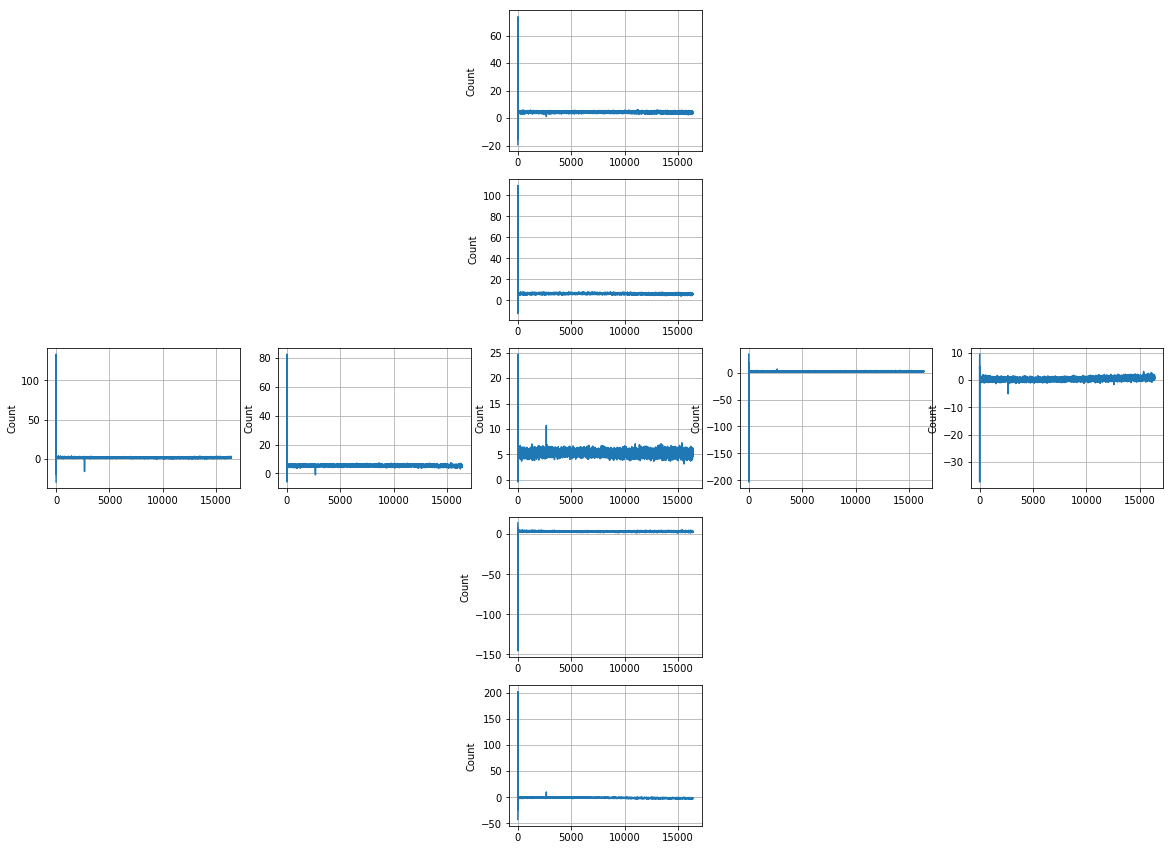

In [220]:
fig = plt.figure(figsize = (20,15))

axlist = [fig.add_subplot(5,5,i+1) for i in range(25)]

axlist[2].plot(yscan_Ta[0])
axlist[2].set_xlabel("")
axlist[2].set_ylabel("Count")
axlist[2].grid()

axlist[7].plot(yscan_Ta[1])
axlist[7].set_xlabel("")
axlist[7].set_ylabel("Count")
axlist[7].grid()

axlist[10].plot(xscan_Ta[0])
axlist[10].set_xlabel("")
axlist[10].set_ylabel("Count")
axlist[10].grid()

axlist[11].plot(xscan_Ta[1])
axlist[11].set_xlabel("")
axlist[11].set_ylabel("Count")
axlist[11].grid()

# axlist[12].plot(xscan_Ta[2])
axlist[12].plot(yscan_Ta[2])
axlist[12].set_xlabel("")
axlist[12].set_ylabel("Count")
axlist[12].grid()

axlist[13].plot(xscan_Ta[3])
axlist[13].set_xlabel("")
axlist[13].set_ylabel("Count")
axlist[13].grid()

axlist[14].plot(xscan_Ta[4])
axlist[14].set_xlabel("")
axlist[14].set_ylabel("Count")
axlist[14].grid()

axlist[17].plot(yscan_Ta[3])
axlist[17].set_xlabel("")
axlist[17].set_ylabel("Count")
axlist[17].grid()

axlist[22].plot(yscan_Ta[4])
axlist[22].set_xlabel("")
axlist[22].set_ylabel("Count")
axlist[22].grid()

axlist[0].set_visible(False)
axlist[1].set_visible(False)
axlist[3].set_visible(False)
axlist[4].set_visible(False)
axlist[5].set_visible(False)
axlist[6].set_visible(False)
axlist[8].set_visible(False)
axlist[9].set_visible(False)
axlist[15].set_visible(False)
axlist[16].set_visible(False)
axlist[18].set_visible(False)
axlist[19].set_visible(False)
axlist[20].set_visible(False)
axlist[21].set_visible(False)
axlist[23].set_visible(False)
axlist[24].set_visible(False)

plt.show()